In [1]:
import scipy

In [2]:
import csv

In [3]:
import numpy as np

In [4]:
ir = np.genfromtxt('impResp2.csv')
total_len = 1024
front_pad = 128
ir[0] = 0.119775

In [5]:
from matplotlib import pyplot as plt

In [6]:
import numpy as np

<IPython.core.display.Javascript object>


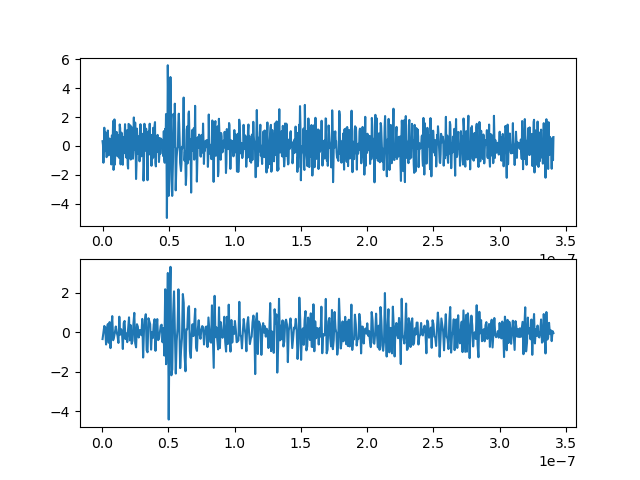

In [7]:
%matplotlib notebook
fig=plt.figure()
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

In [8]:
from scipy import signal

In [9]:
ir3 = scipy.signal.resample_poly(ir, 3, 10)
total_with_pad = 1536
pad_end = total_with_pad - len(ir3) - front_pad
ir3 = np.pad(ir3, [front_pad, pad_end], mode='constant')
# These define our band. They'll be used for both signal and noise.
hpsos = scipy.signal.butter(5, 0.1666, btype='highpass', output='sos')
lpsos = scipy.signal.butter(5, 0.8, btype='lowpass', output='sos')
ir3 = scipy.signal.sosfilt(lpsos, ir3)
ir3 = scipy.signal.sosfilt(hpsos, ir3)
# Now normalize to the peak. Note that we do this *here* after the highpass, but before any interpolation.
ir3_p2p = np.amax(ir3)-np.amin(ir3)
ir3 = ir3/(ir3_p2p/2)

In [10]:
# this is from TFilter, 0-650 Hz 1 dB ripple, 750-1500 Hz 30 dB rejection. Not *super* attached to this.
trig_lpf = [ 0.008221498626438355
,0.022467600608263687
,-0.005735806817546407
,-0.011305635285472695
,0.000048253848191315944
,0.016226723878188614
,0.0030049330597322955
,-0.01985335970710756
,-0.008747581736113496
,0.023662964861940212
,0.017313676075751187
,-0.027161918283047173
,-0.03041376298199074
,0.030156958746321648
,0.052323744831867386
,-0.0324770203662481
,-0.09907231876330876
,0.03391802170142495
,0.3159219034492574
,0.46558749845556885
,0.3159219034492574
,0.03391802170142495
,-0.09907231876330876
,-0.0324770203662481
,0.052323744831867386
,0.030156958746321648
,-0.03041376298199074
,-0.027161918283047173
,0.017313676075751187
,0.023662964861940212
,-0.008747581736113496
,-0.01985335970710756
,0.0030049330597322955
,0.016226723878188614
,0.000048253848191315944
,-0.011305635285472695
,-0.005735806817546407
,0.022467600608263687
,0.008221498626438355
]

In [11]:
from scipy import ndimage
# Figure out the signal phase
ir3_phase = np.random.random_sample()
# shift it
this_ir3 = scipy.ndimage.shift(ir3, ir3_phase)
snr = 5
# Noise is flat originally, shaped by bandpass
noise = np.random.normal(0, 1, this_ir3.shape)
noise = scipy.signal.sosfilt(lpsos, noise)
noise = scipy.signal.sosfilt(hpsos, noise)
# Scale the signal by desired SNR.
rms = np.std(noise)
noise /= rms
this_ir3 = this_ir3*snr + noise

In [12]:
t = np.arange(total_len)*(0.333e-9)

In [13]:
ax.plot(t, this_ir3[0:total_len])

In [14]:
this_afterlp = scipy.signal.lfilter(trig_lpf, [1], this_ir3)
# Correct for impulse delay of filter
this_afterlp = this_afterlp[int((len(trig_lpf)-1)/2):]
# Decimate by 2. Random phase.
lp_ph = np.random.randint(0,2)
this_afterlp = this_afterlp[lp_ph::2]
t_afterlp = t[lp_ph::2]
ax2.plot(t_afterlp, this_afterlp[0:len(t_afterlp)])

<IPython.core.display.Javascript object>


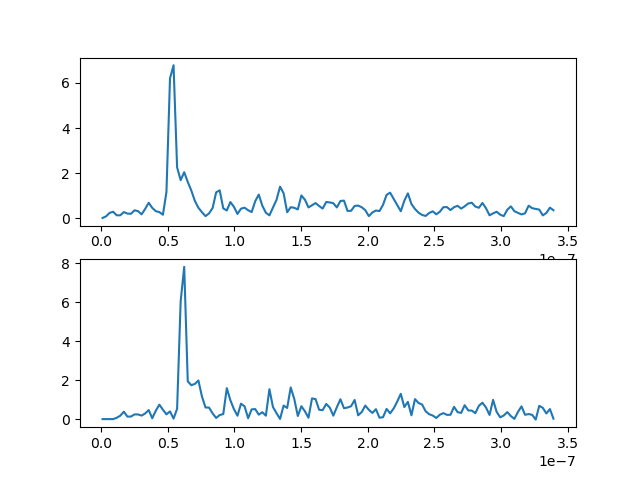

In [15]:
tfig=plt.figure()
tax = tfig.add_subplot(211)
tax2 = tfig.add_subplot(212)

In [16]:
this_power = np.square(this_afterlp)
# Random clock phase
pph = np.random.randint(0, 4)
# FIR-filter average with DC gain = 1. Only 8 samples because we already decimated.
avg = [ (1/8) ] * 8
simple_power = scipy.signal.lfilter(avg, [1], this_power)[pph::4]
# Simple halfband first. We scale this for DC gain = 1 as well
hb1 = scipy.signal.firwin(9, 0.5)
# Decimate by 2. If pph == 1 or 3 we start from second one here
lp1_power = scipy.signal.lfilter(hb1, [1], this_power)[(pph % 2)::2]
hb2 = scipy.signal.firwin(13, 0.5)
# Decimate by 2. If pph = 3 or 4 we pick off the second one here
lp2_power = scipy.signal.lfilter(hb2, [1], lp1_power)[int(pph/2)::2]
t_power = t_afterlp[pph::4]
tax.plot(t_power, simple_power[0:len(t_power)])
tax2.plot(t_power, lp2_power[0:len(t_power)])

In [17]:
print(np.average(simple_power[96:128]), "+/-", np.std(simple_power[96:128]), np.average(lp2_power[96:128]), "+/-", np.std(lp2_power[96:128]))

0.3932392234354828 +/- 0.16307113155570913 0.3837670893879958 +/- 0.243607159198505


In [18]:
print(np.max(simple_power), np.max(lp2_power))

6.780885079600245 7.825802583987121


In [19]:
(np.max(this_ir3)-np.min(this_ir3))/(2*np.std(this_ir3[768:]))

5.431043575004099

In [20]:
(np.max(this_afterlp)-np.min(this_afterlp))/(2*np.std(this_afterlp[384:]))

6.019684223533413

In [21]:
from scipy.fft import fft, fftfreq

In [22]:
tir3f = fft(this_ir3)

<IPython.core.display.Javascript object>


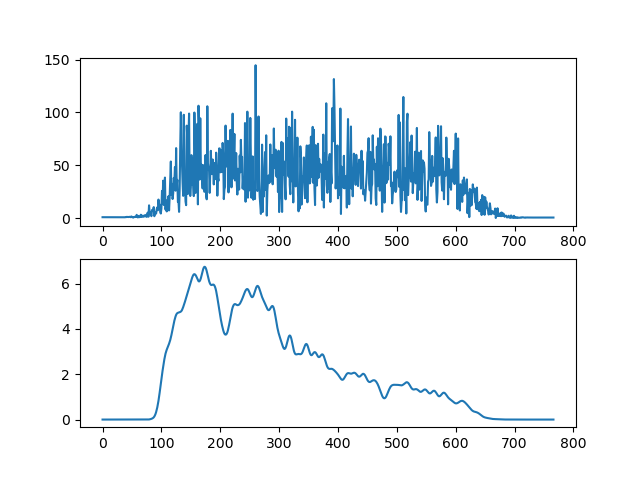

In [23]:
ffig = plt.figure()
fax = ffig.add_subplot(211)
fax2 = ffig.add_subplot(212)

In [24]:
fax.plot(np.abs(tir3f)[1:768])

In [25]:
ir3f = fft(ir3)
fax2.plot(np.abs(ir3f)[1:768])

<IPython.core.display.Javascript object>


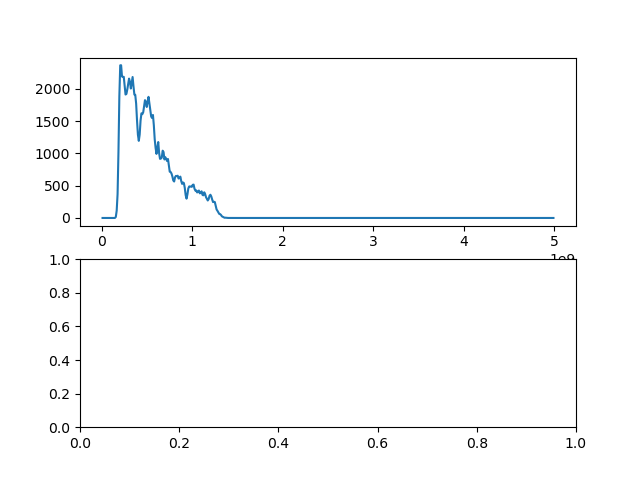

In [26]:
ifig = plt.figure()
iax = ifig.add_subplot(211)
iax2 = ifig.add_subplot(212)
irf = fft(ir)
irfs = fftfreq(1024, 0.1E-9)[:512]
iax.plot(irfs[1:512], np.abs(irf)[1:512])
# ir3 = scipy.signal.resample_poly(ir, 3, 10, window=('kaiser',5.0))
# ir3f = fft(ir3[0:256])
# iax2.plot(np.abs(ir3f[1:128]))

In [27]:
avg8 = [ 1/8 ]*8

<IPython.core.display.Javascript object>


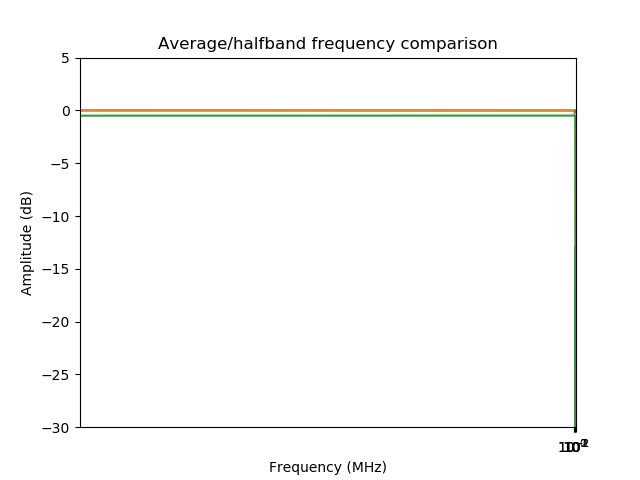

<ipython-input-28-b25635eae21a>:6: RuntimeWarning: divide by zero encountered in log10
  aax1.plot(w, 20*np.log10(abs(h)))


In [28]:
w,h = scipy.signal.freqz(b=avg8, fs=1500)
w2,h2=scipy.signal.freqz(b=scipy.signal.firwin(13,0.5),fs=750)
w3,h3=scipy.signal.sosfreqz(scipy.signal.cheby1(2,0.5,0.2,output='sos'),fs=750)
afig = plt.figure()
aax1 = afig.add_subplot(111)
aax1.plot(w, 20*np.log10(abs(h)))
aax1.set_ylabel('Amplitude (dB)')
aax1.set_xlabel('Frequency (MHz)')
aax1.plot(w2, 20*np.log10(abs(h2)))
aax1.plot(w3, 20*np.log10(abs(h3)))
aax1.set_ylim([-30,5])
aax1.set_xlim([0,750])
aax1.title.set_text("Average/halfband frequency comparison")

In [29]:
scipy.signal.cheb1ord(0.6,0.8,1,20)

(3, 0.6)

In [30]:
nb, na = signal.iirnotch(380, 30, 3000)

In [31]:
nb

array([ 0.98690838, -1.38100723,  0.98690838])

In [32]:
na

array([ 1.        , -1.38100723,  0.97381677])

In [33]:
np.rint(scipy.signal.firwin(13, 0.5,scale=False)*4096)

array([   0.,   37.,   -0., -235.,    0., 1223., 2048., 1223.,    0.,
       -235.,   -0.,   37.,    0.])

In [35]:
z, p, k = scipy.signal.cheby1(2, 0.5, 0.2, output='zpk')

In [36]:
z

array([-1., -1.])

In [37]:
p

array([0.51742678+0.4019424j, 0.51742678-0.4019424j])

In [38]:
p[0]

(0.5174267814682382+0.4019423950385471j)

In [39]:
np.abs(p[0])

0.6552008570735415

In [40]:
np.angle(p[0])

0.6604400028106422

In [41]:
b,a = scipy.signal.iirnotch(380, 8, fs=3000)

In [46]:
nzs, nps, nk = scipy.signal.tf2zpk(b, a)

In [47]:
import numpy as np

In [49]:
print(np.abs(nzs[0]), np.angle(nzs[0]))

1.0 0.7958701389094144


In [50]:
print(np.abs(nps[0]), np.angle(nps[0]))

0.9513967255749552 0.794653667896822


In [51]:
b

array([ 0.95257786, -1.33296762,  0.95257786])

In [52]:
a

array([ 1.        , -1.33296762,  0.90515573])

In [53]:
np.abs(nzs[1])

1.0

In [54]:
np.angle(nps[1])

-0.794653667896822

In [55]:
nps[0]

(0.6664838109272462+0.6789367122248152j)

In [59]:
Amr = np.real(np.power(nps[0],8))

In [60]:
Ami = np.imag(np.power(nps[0],8))

In [61]:
np.power(Amr, 2)+np.power(Ami, 2)

0.4505950723041469

In [62]:
2*Amr-(np.power(Amr, 2)+np.power(Ami, 2))

0.8882539669901268

In [64]:
np.power(nps[1], 8)

(0.6694245196471369-0.04965767613719927j)

In [65]:
np.power(nps[0], 8)

(0.6694245196471369+0.04965767613719927j)

In [68]:
nk/(2*np.cos(np.angle(nzs[0])))

0.6807401571293105

In [168]:
b2,a2 = scipy.signal.iirnotch(375, 10, fs=3000)
nzs2, nps2, nk2 = scipy.signal.tf2zpk(b2, a2)

In [169]:
nk2

0.9621952458291035

In [170]:
np.angle(nps2[0],deg=True)

44.95570750173303

In [173]:
import cmath

In [197]:
pole=complex(np.sqrt(2)/2, np.sqrt(2)/2)*np.abs(nps2[0])

In [198]:
cpole=np.conjugate(pole)

In [199]:
p = [ pole, cpole ]

In [205]:
w , h = scipy.signal.freqs_zpk(nzs2, p, nk2)
w2 , h2 = scipy.signal.freqs_zpk(nzs2, nps2, nk2)

In [206]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


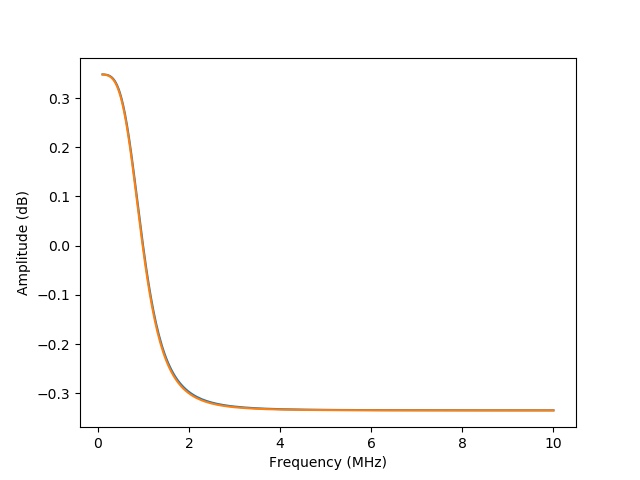

Text(0.5, 0, 'Frequency (MHz)')

In [207]:
pfig = plt.figure()
pax1 = pfig.add_subplot(111)
pax1.plot(w, 20*np.log10(abs(h)))
pax1.plot(w2, 20*np.log10(abs(h2)))
pax1.set_ylabel('Amplitude (dB)')
pax1.set_xlabel('Frequency (MHz)')

In [203]:
p

[(0.6798494287922169+0.6798494287922169j),
 (0.6798494287922169-0.6798494287922169j)]

In [204]:
nps2

array([0.68037478+0.67932367j, 0.68037478-0.67932367j])

In [189]:
p

[(0.7071067811865476+0.7071067811865476j),
 (0.7071067811865476-0.7071067811865476j)]

In [902]:
fs = 3000.0  # Sample frequency (Hz)
f0 = 375.0  # Frequency to be removed from signal (Hz)
Q = 5 # Quality factor
Q2 = 10
# Design notch filter
b, a = signal.iirnotch(f0, Q, fs)
b2, a2 = signal.iirnotch(f0, Q2, fs)
zeros, poles, gain = scipy.signal.tf2zpk(b, a)
z2, p2, g2 = scipy.signal.tf2zpk(b2, a2)
filt2 =  [[ 1.0000,   -1.4020,    1.0000,    1.0000,   -1.3536,    0.9589],
          [ 1.0000,   -1.4262,    1.0000,    1.0000,   -1.4165,    0.9606]]
newpole = complex(np.sqrt(2)/2, np.sqrt(2)/2)*np.abs(poles[0])
newpoles = [ newpole, np.conjugate(newpole) ]

<IPython.core.display.Javascript object>


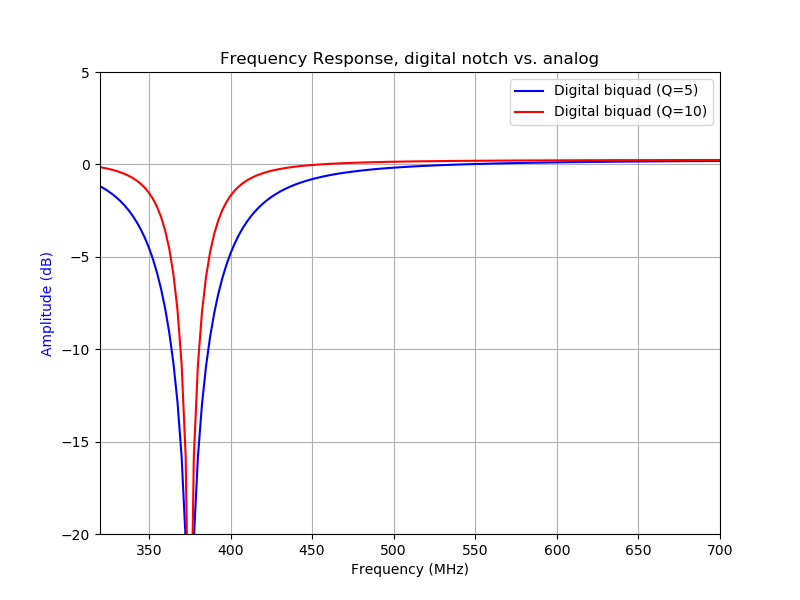

In [904]:
# Frequency response
freq, h = signal.freqz_zpk(zeros, poles, gain, fs=fs, worN=600)
f2, h2 = signal.freqz_zpk(z2, p2, g2, fs=fs, worN=600)
f3, h3 = signal.sosfreqz( filt2, worN=600, fs=fs )
newfreq, newh = signal.freqz_zpk(zeros, newpoles, gain, fs=fs, worN=600)
fcomp=[]
mag = []
with open('oldFilt.csv') as csvfile:
    rd = csv.reader(csvfile, delimiter=',')
    for row in rd:
            fcomp.append(float(row[0]))
            mag.append(float(row[1])+0.3)
# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(freq, 20*np.log10(abs(h)+3E-2), color='blue', label='Digital biquad (Q=5)')
ax.plot(f2, 20*np.log10(abs(h2)+3E-2), color='red', label='Digital biquad (Q=10)')
#ax.plot(f3, 20*np.log10(abs(h3)+3E-2)-1, color='green', label='Digital dual biquad')
#ax.plot(fcomp, mag, color='red', label='ANITA-4 TUFF')
ax.legend()
#ax[0].plot(newfreq, 20*np.log10(abs(newh)+3E-2), color='red')
ax.set_title("Frequency Response, digital notch vs. analog")
ax.set_ylabel("Amplitude (dB)", color='blue')
ax.set_xlabel("Frequency (MHz)")
ax.set_xlim([320, 700])
ax.set_ylim([-20, 5])
ax.grid()
# ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
# #ax[1].plot(newfreq, np.unwrap(np.angle(newh))*180/np.pi, color='purple')
# ax[1].set_ylabel("Angle (degrees)", color='green')
# ax[1].set_xlabel("Frequency (MHz)")
# ax[1].set_xlim([300, 700])
# ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
# ax[1].set_ylim([-90, 90])
# ax[1].grid()
plt.show()

In [247]:
np.angle(poles[0], deg=True)

45.55545886329521

In [250]:
2*np.cos(np.angle(poles[0])*8)*4096-8192

-24.625256156755313

In [293]:
float(mag[0])

-3.1547

In [318]:
scipy.signal.zpk2sos(z2, p2, g2)

array([[ 0.98074073, -1.38697684,  0.98074073,  1.        , -1.38697684,
         0.96148145]])

In [334]:
z,p,k=scipy.signal.sos2zpk(filt2)

In [337]:
print(np.angle(p[0], deg=True), np.angle(p[2], deg=True))

48.90203000655809 41.178974317054546


[0.06841672478526716, 0.1368334495705343, 0.06841672478526716] [1, -1.2247448713915892, 0.5]
(array([0.06841672, 0.13683345, 0.06841672]), array([ 1.        , -1.19915076,  0.48906682]))
5.810325581741937 0.48906682041027555


<IPython.core.display.Javascript object>


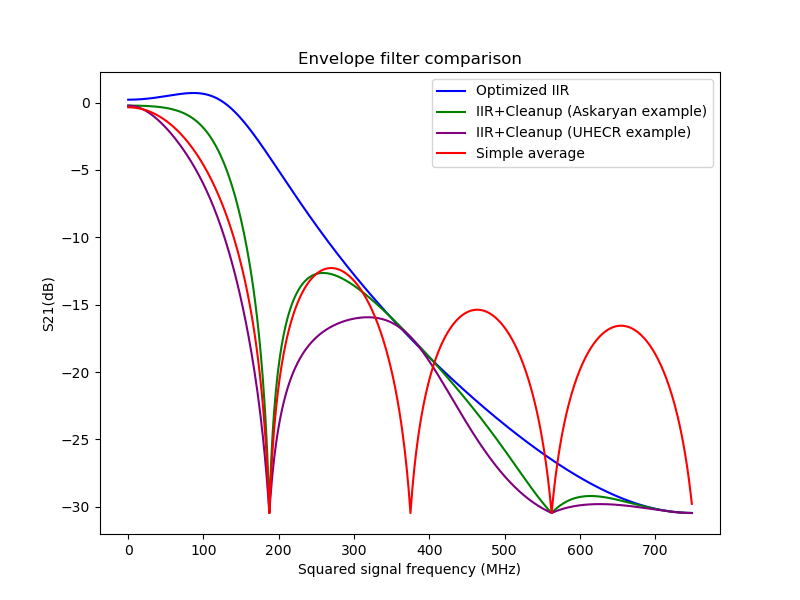

In [586]:
lz,lp,lk = scipy.signal.cheby1(2, 0.501, 0.166,output='zpk')
myb = [ 1*lk, 2*lk, 1*lk ]
mya = [ 1, -1*np.cos(np.pi/6)*np.power(2,0.5), 0.5]
print(myb, mya)
print(scipy.signal.zpk2tf(lz,lp,lk))
print(1/(np.angle(lp[0])/(np.pi)), np.power(np.abs(lp[0]), 2))
lf, lh = signal.freqz_zpk(lz, lp, lk, fs=1500, worN=600)
myf, myh = signal.freqz(myb, mya, fs=1500, worN=600)
sf, sh = signal.freqz(b=[(1/8)*0.93 ]*8, fs=1500, worN=600)
sf2, sh2 = signal.freqz(b=[1]+[0]*3, fs=1500, worN=600)
cb, ca = signal.butter(1, 0.6)
cb2, ca2 = signal.butter(1, 0.34)
newb = [ cb[0] ] + [0]*3 + [ cb[1] ] + [0]*3
newa = [ ca[0] ] + [0]*3 + [ ca[1] ] + [0]*3
newa2 =[ ca2[0] ]+ [0]*3 + [ ca2[1] ] + [0]*3
newb2 =[ cb2[0]] + [0]*3 + [ cb2[1]] + [0]*3

cf, ch = signal.freqz(newb, newa, fs=1500, worN=600)
cf2, ch2 = signal.freqz(newb2, newa2, fs=1500, worN=600)
# Plot
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
ax2.set_title("Envelope filter comparison")
ax2.set_xlabel("Squared signal frequency (MHz)")
ax2.set_ylabel("S21(dB)")
ax2.plot(myf, 20*np.log10(abs(myh)+3e-2), color='blue', label='Optimized IIR')
ax2.plot(cf, 20*np.log10(abs(ch*lh)+3E-2), color='green', label='IIR+Cleanup (Askaryan example)')
ax2.plot(cf, 20*np.log10(abs(ch2*lh)+3E-2), color='purple', label='IIR+Cleanup (UHECR example)')
ax2.plot(sf, 20*np.log10(abs(sh*sh2)+3E-2), color='red', label='Simple average')
ax2.legend()

In [379]:
np.cos(np.angle(lp[0]))

0.27395147170889844

In [380]:
np.abs(lp[0])

0.5235750065872479

In [460]:
scipy.signal.zpk2tf(lz,lp,lk)

(array([0.06562154, 0.13124307, 0.06562154]),
 array([ 1.        , -1.2206375 ,  0.49996029]))

In [439]:
np.power(0.50957762, 2)

0.25966935080486436

In [466]:
cb,ca = scipy.signal.butter(1, 0.6)


In [467]:
print(cb, ca)

[0.57919222 0.57919222] [1.         0.15838444]


In [477]:
newb = [ cb[0] ] + [0]*3 + [ cb[1] ] + [0]*3
newa = [ ca[0] ] + [0]*3 + [ ca[1] ] + [0]*3

In [478]:
print(newb, newa)

[0.6624598481164531, 0, 0, 0, 0.6624598481164531, 0, 0, 0] [1.0, 0, 0, 0, 0.3249196962329063, 0, 0, 0]


In [627]:
nb, na = scipy.signal.iirnotch(w0=380, Q=4.7, fs=3000)

In [628]:
nzs,nps,nk = scipy.signal.tf2zpk(nb, na)

In [629]:
np.abs(nps[0])

0.9184437795842947

In [526]:
lk

0.06483475022792895

In [531]:
scipy.signal.tf2sos(myb, mya)

array([[ 0.06483475,  0.1296695 ,  0.06483475,  1.        , -1.22474487,
         0.5       ]])

<IPython.core.display.Javascript object>


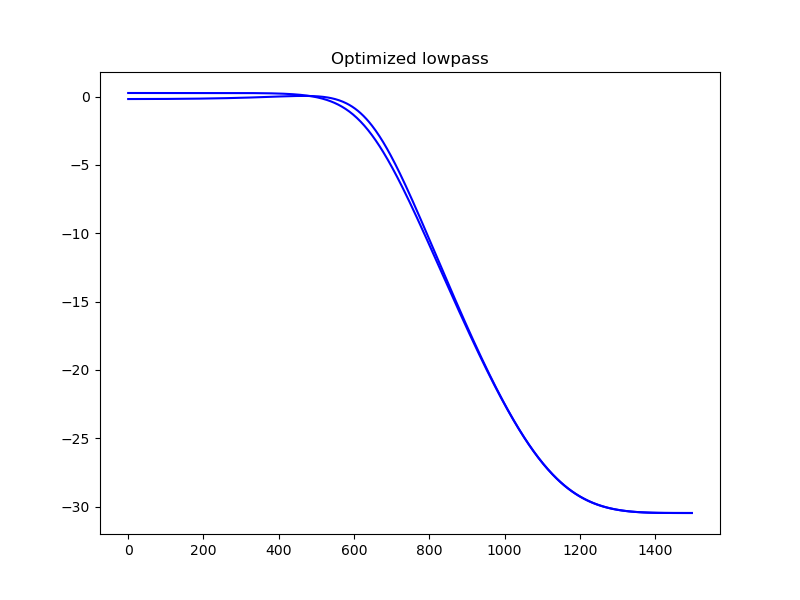

In [638]:
b2 = scipy.signal.butter(4, 0.4285714, output='sos')
nk = 0.057903057461400405
thisp = 0.22854998104736002
sos1 = [ nk, 2*nk, nk, 1, -2*thisp*np.cos(np.pi/3), thisp*thisp ]
sos2 = [ 1, 2, 1, 1, -1*np.sqrt(2)*np.cos(3*np.pi/7), 0.5 ]
g = [ sos1, sos2 ]
gf, gh = signal.sosfreqz(g, fs=3000, worN=600)
bf, bh = signal.sosfreqz(b2, fs=3000, worN=600)
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 6))
ax3.set_title("Optimized lowpass")
ax3.plot(gf, 20*np.log10(abs(gh)+3e-2), color='blue', label='Optimized IIR')
ax3.plot(bf, 20*np.log10(abs(bh)+3e-2), color='blue', label='Optimized IIR')

In [691]:
from scipy import special
from scipy import linalg

In [1014]:
def getpoles(freq, q, piped=False, quantize=False, verbose=False):
    nb, na = scipy.signal.iirnotch(w0=freq, Q=q, fs=3000)
    nzs,nps,nk = scipy.signal.tf2zpk(nb, na)
    pole = np.abs(nps[0])
    ang = np.angle(nps[0])
    updmx = np.ndarray(shape=(2,2))
    updmx[0][0] = -1*np.power(pole, 8)*special.eval_chebyu(6, np.cos(ang))
    updmx[0][1] = np.power(pole, 7)*special.eval_chebyu(7, np.cos(ang))
    updmx[1][0] = -1*np.power(pole, 9)*special.eval_chebyu(7, np.cos(ang))
    updmx[1][1] = np.power(pole, 8)*special.eval_chebyu(8, np.cos(ang))
    if piped:
        updmx = np.linalg.matrix_power(updmx, 2)
    if quantize:
        updmx = np.round(updmx*16384)        
    if verbose:
        print(updmx)
    if quantize:
        updmx = updmx/16384
    return np.abs(linalg.eigvals(updmx))

<IPython.core.display.Javascript object>


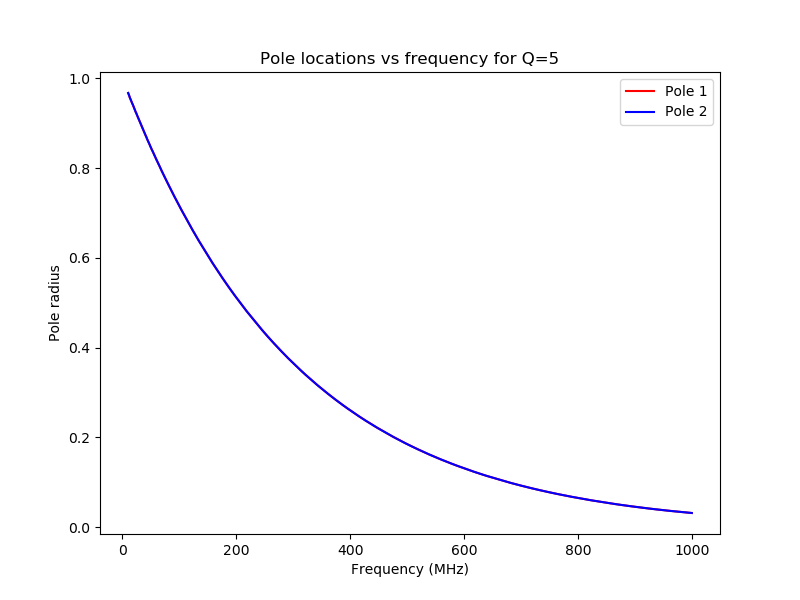

In [1016]:
freqs = np.arange(10,1000,1)
p0 = []
p1 = []
for f in freqs:
    poles = getpoles(f, 5, piped=True, quantize=True)
    p0.append(poles[0])
    p1.append(poles[1])
fig4, ax4 = plt.subplots(1, 1, figsize=(8, 6))
ax4.set_title("Pole locations vs frequency for Q=5")
ax4.set_xlabel("Frequency (MHz)")
ax4.set_ylabel("Pole radius")
ax4.plot(freqs, p0, color='red', label='Pole 1')
ax4.plot(freqs, p1, color='blue', label='Pole 2')
ax4.legend()

In [1019]:
def plot(q):
    freqs = np.arange(10,1450,1)
    p0 = []
    p1 = []
    for f in freqs:
        poles = getpoles(f, q, piped=True, quantize=True)
        p0.append(poles[0])
        p1.append(poles[1])
    fig5 = None
    ax5 = None
    fig5, ax5 = plt.subplots(1, 1, figsize=(8, 6))
    title = "Pole locations vs frequency for Q="+str(q)
    ax5.set_title(title)
    ax5.set_xlabel("Frequency (MHz)")
    ax5.set_ylabel("Pole radius")
    ax5.plot(freqs, p0, color='red', label='Pole 1')
    ax5.plot(freqs, p1, color='blue', label='Pole 2')
    ax5.legend()

<IPython.core.display.Javascript object>


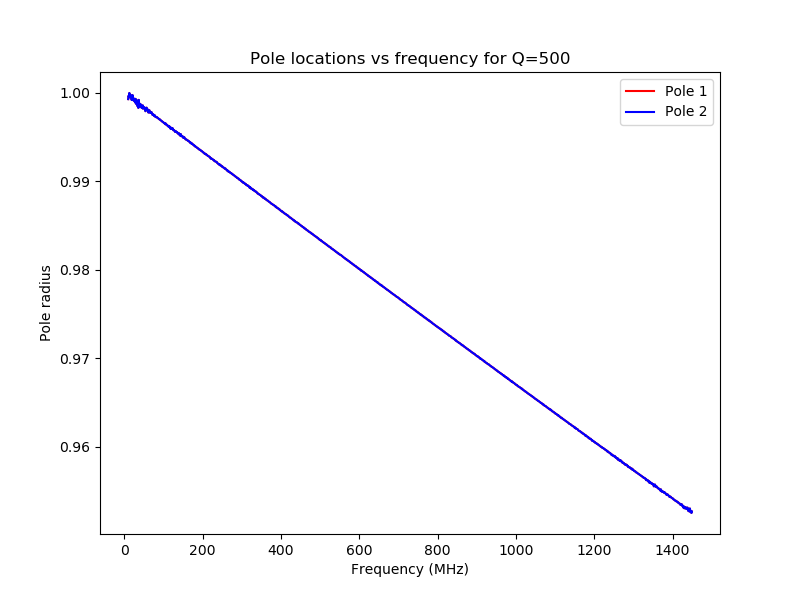

In [1029]:
plot(500)

In [1011]:
def sosgetpoles(sos, piped=False, quantize=False, verbose=False):
    poles = []
    for section in sos:
        nzs,nps,nk = scipy.signal.sos2zpk([section])
        pole = np.abs(nps[0])
        ang = np.angle(nps[0])
        updmx = np.ndarray(shape=(2,2))
        updmx[0][0] = -1*np.power(pole, 8)*special.eval_chebyu(6, np.cos(ang))
        updmx[0][1] = np.power(pole, 7)*special.eval_chebyu(7, np.cos(ang))
        updmx[1][0] = -1*np.power(pole, 9)*special.eval_chebyu(7, np.cos(ang))
        updmx[1][1] = np.power(pole, 8)*special.eval_chebyu(8, np.cos(ang))
        if piped:
            updmx = np.linalg.matrix_power(updmx, 2)
        if quantize:
            updmx = np.round(updmx*16384)
        if verbose:
            print(updmx)
        if quantize:
            updmx = updmx/16384
        poles.append(np.abs(linalg.eigvals(updmx)))
    return poles

In [1012]:
sos0 =  [[ 1.0000,   -1.4020,    1.0000,    1.0000,   -1.3536,    0.9589],
          [ 1.0000,   -1.4262,    1.0000,    1.0000,   -1.4165,    0.9606]]

In [1033]:
sosgetpoles(sos0, piped=True, quantize=True, verbose=True)

[[ 7058.  5784.]
 [-5546. 14887.]]
[[15456. -6098.]
 [ 5857.  6818.]]


[array([0.7147905, 0.7147905]), array([0.72499642, 0.72499642])]

In [734]:
def sosnotch(freq, q, fs=3000):
    myb, mya = signal.iirnotch(freq, q, fs)
    return signal.tf2sos(myb, mya)

In [857]:
n0 = sosnotch(375, 5)
sosgetpoles(n0)

[[10460.30356668  -333.59781141]
 [  308.29937414  8496.58549237]]


[array([0.63515947, 0.52187722])]

In [750]:
bA, aA = signal.iirnotch(375., 1000, fs=3000)
zA, pA, kA = signal.tf2zpk(bA, aA)
print(np.abs(zA[0]), np.angle(zA[0], deg=True))
print((1-np.abs(pA[0]))*1E3, 45-np.angle(pA[0], deg=True))

1.0 45.0
0.3926220258632096 4.417865802963661e-06


In [742]:
signal.iirnotch(375., 1000, fs=3000)

(array([ 0.96219525, -1.36074957,  0.96219525]),
 array([ 1.        , -1.36074957,  0.92439049]))

In [764]:
def newpole(freq, q):
    nb, na = scipy.signal.iirnotch(w0=freq, Q=q, fs=3000)
    nzs,nps,nk = scipy.signal.tf2zpk(nb, na)
    pole = np.abs(nps[0])
    ang = np.angle(nps[0])
    nb = np.power(pole, 8)*special.eval_chebyu(8, np.cos(ang))-np.power(pole, 6)*special.eval_chebyu(6, np.cos(ang))
    nc = np.power(pole, 14)
    return np.abs(np.roots([1, nb, nc]))

In [766]:
newpole(10, 5)

array([0.98544614, 0.98544614])

In [767]:
def newplot(q):
    freqs = np.arange(10,1000,1)
    p0 = []
    p1 = []
    for f in freqs:
        poles = newpole(f, q)
        p0.append(poles[0])
        p1.append(poles[1])
    fig5 = None
    ax5 = None
    fig5, ax5 = plt.subplots(1, 1, figsize=(8, 6))
    title = "Pole locations vs frequency for Q="+str(q)
    ax5.set_title(title)
    ax5.set_xlabel("Frequency (MHz)")
    ax5.set_ylabel("Pole radius")
    ax5.plot(freqs, p0, color='red', label='Pole 1')
    ax5.plot(freqs, p1, color='blue', label='Pole 2')
    ax5.legend()

<IPython.core.display.Javascript object>


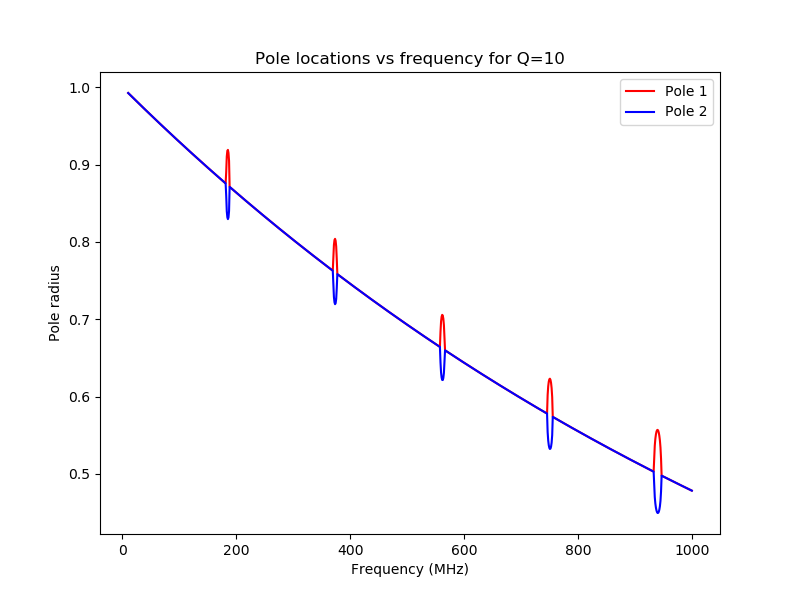

In [783]:
newplot(10)

In [1032]:
getpoles(460, 5, piped=True, quantize=True, verbose=True)

[[-4092.  1582.]
 [-1303. -2445.]]


array([0.21201514, 0.21201514])

In [905]:
def poles(freq, q):
    b, a = signal.iirnotch(freq, q, fs=3000)
    z, p, k = signal.tf2zpk(b, a)
    print("Zero: ", np.abs(z[0]), np.angle(z[0], deg=True))
    print("Pole: ", np.abs(p[0]), np.angle(p[0], deg=True))

In [906]:
poles(460, 5)

Zero:  1.0 55.199999999999996
Pole:  0.9076069015316292 55.01251568831689


In [1034]:
def gain(freq, q):
    b, a = signal.iirnotch(freq, q, fs=3000)
    z, p, k = signal.tf2zpk(b, a)
    return k

In [1039]:
def gainplot(q):
    freqs = np.arange(10,1000,1)
    ks = []
    for f in freqs:
        k = gain(f, q)
        ks.append(k)
    fig5 = None
    ax5 = None
    fig5, ax5 = plt.subplots(1, 1, figsize=(8, 6))
    title = "Gain vs frequency for Q="+str(q)
    ax5.set_title(title)
    ax5.set_xlabel("Frequency (MHz)")
    ax5.set_ylabel("Gain")
    ax5.plot(freqs, ks, color='blue', label='Gain')
    ax5.legend()

<IPython.core.display.Javascript object>


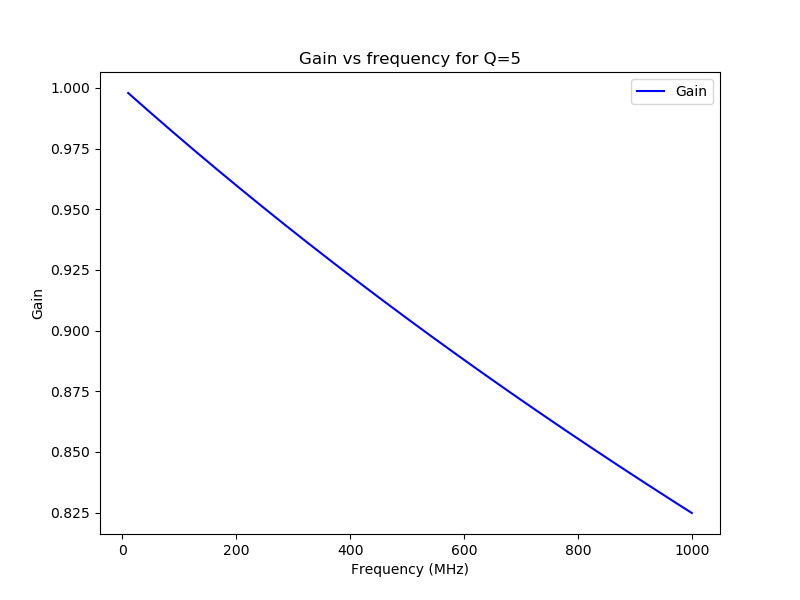

In [1042]:
gainplot(5)